## Inspect Plate Artifacts - Batch 3

**Gregory Way, 2019**

In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(platetools))
suppressPackageStartupMessages(library(ggplot2))

In [2]:
count_cells <- function(plate_name) {
    # Determine SQL file name
    project <- "2018_05_30_ResistanceMechanisms_Kapoor"
    bucket_dir <- file.path("~", "bucket", "projects", project, "workspace", "backend")
    sqlite_file <- file.path(bucket_dir, batch, plate_name, paste0(plate_name, ".sqlite"))
    
    # Setup a connection
    con <- RSQLite::dbConnect(drv = RSQLite::SQLite(),
                              dbname = sqlite_file)
    
    # Connect to image table
    image_df <- dplyr::tbl(
        con,
        dbplyr::sql("SELECT TableNumber, ImageNumber, Metadata_Plate, Metadata_Well from image")
    )
    
    # Connect to cells table
    cells_df <- dplyr::tbl(
        con,
        dbplyr::sql("SELECT TableNumber, ImageNumber from cells")
    )
    
    # Merge them together and count cells per well
    count_df <- cells_df %>%
        dplyr::inner_join(image_df,
                          by = c("TableNumber", "ImageNumber")) %>%
        dplyr::group_by(Metadata_Plate, Metadata_Well) %>%
        dplyr::count()
    
    return(count_df)
}

In [3]:
batch <- "2019_06_25_Batch3"
backend_dir <- file.path("..", "..", "backend", batch)

backend_folders = list.files(backend_dir, full.names = FALSE)

backend_files = list()
for (backend_file in backend_folders) {
    backend_files[[backend_file]] <-
        file.path(backend_dir, backend_file, paste0(backend_file, "_normalized_variable_selected.csv"))
}

backend_files

$MutClones
[1] "../../backend/2019_06_25_Batch3/MutClones/MutClones_normalized_variable_selected.csv"

$WTClones
[1] "../../backend/2019_06_25_Batch3/WTClones/WTClones_normalized_variable_selected.csv"

## Load Data

In [4]:
mut_df <- readr::read_csv(backend_files[["MutClones"]],
                          col_types=readr::cols())

print(dim(mut_df))
head(mut_df, 2)

[1]  57 191


Metadata_Plate,Metadata_Well,Metadata_Assay_Plate_Barcode,Metadata_Plate_Map_Name,Metadata_well_position,Metadata_clone_number,Cells_AreaShape_Compactness,Cells_AreaShape_EulerNumber,Cells_AreaShape_Extent,Cells_AreaShape_FormFactor,⋯,Nuclei_Texture_Correlation_AGP_20_00,Nuclei_Texture_Correlation_AGP_20_03,Nuclei_Texture_Correlation_AGP_5_00,Nuclei_Texture_Correlation_ER_20_02,Nuclei_Texture_Correlation_Mito_5_00,Nuclei_Texture_Correlation_RNA_20_02,Nuclei_Texture_InfoMeas1_Mito_5_00,Nuclei_Texture_InverseDifferenceMoment_AGP_20_02,Nuclei_Texture_InverseDifferenceMoment_DNA_20_03,Nuclei_Texture_InverseDifferenceMoment_ER_20_02
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
MutClones,B02,MutClones,MutClones,B02,BZ001,0.6034418,-3.05703,0.05068862,0.6585738,⋯,3.3582920,1.126295,0.00000,1.204256,0.4206682,0.5705776,-1.320394,-0.2247533,1.311671,0.212493
MutClones,B03,MutClones,MutClones,B03,BZ002,-1.0295421,-1.41911,1.11426953,-0.9345095,⋯,-0.3068762,1.536572,-4.29316,3.379792,-6.8157241,0.4181798,3.899485,2.1667509,2.502230,2.646517


In [5]:
wt_df <- readr::read_csv(backend_files[["WTClones"]],
                         col_types=readr::cols())

print(dim(wt_df))
head(wt_df, 2)

[1]  48 191


Metadata_Plate,Metadata_Well,Metadata_Assay_Plate_Barcode,Metadata_Plate_Map_Name,Metadata_well_position,Metadata_clone_number,Cells_AreaShape_Compactness,Cells_AreaShape_EulerNumber,Cells_AreaShape_Extent,Cells_AreaShape_FormFactor,⋯,Nuclei_Texture_Correlation_AGP_20_00,Nuclei_Texture_Correlation_AGP_20_03,Nuclei_Texture_Correlation_AGP_5_00,Nuclei_Texture_Correlation_ER_20_02,Nuclei_Texture_Correlation_Mito_5_00,Nuclei_Texture_Correlation_RNA_20_02,Nuclei_Texture_InfoMeas1_Mito_5_00,Nuclei_Texture_InverseDifferenceMoment_AGP_20_02,Nuclei_Texture_InverseDifferenceMoment_DNA_20_03,Nuclei_Texture_InverseDifferenceMoment_ER_20_02
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
WTClones,B02,WTClones,WTClones,B02,WT001,-0.68165560,0.2433688,0.5543276,0.27729305,⋯,-1.992909,-0.5624821,-0.7311029,-1.798579,-2.05401899,-1.2708266,0.67166455,-0.08257108,0.4544209,-0.6100711
WTClones,B03,WTClones,WTClones,B03,WT001,0.05125114,-0.4970395,-0.1045300,0.07257513,⋯,-1.922169,-0.7716781,-0.1594808,-1.284761,0.01782447,-0.6921738,-0.06878273,-0.44354985,0.2891828,-0.5773808


In [6]:
cor_file <- file.path("results", "WT_median_replicate_correlation.tsv")
wt_median_cor_df <- readr::read_tsv(cor_file, col_types = readr::cols())

cor_file <- file.path("results", "MUT_median_replicate_correlation.tsv")
mut_median_cor_df  <- readr::read_tsv(cor_file, col_types = readr::cols())

In [7]:
wt_median_cor_df <- wt_df %>%
    dplyr::select(Metadata_Well, Metadata_Plate_Map_Name, Metadata_clone_number) %>%
    dplyr::inner_join(wt_median_cor_df, by = "Metadata_clone_number")

mut_median_cor_df <- mut_df %>%
    dplyr::select(Metadata_Well, Metadata_Plate_Map_Name, Metadata_clone_number) %>%
    dplyr::inner_join(mut_median_cor_df, by = "Metadata_clone_number")

## Count Cells Per Well

Do not recalculate if the data already exist

In [8]:
# Mutant Clone Plate
mut_count_file <- file.path("results", "MutClones_cell_count_by_well.tsv")
if (!file.exists(mut_count_file)) {
    mut_count <- count_cells("MutClones") %>%
        dplyr::collect()
    mut_count %>% readr::write_tsv(mut_count_file)
} else {
    mut_count <- readr::read_tsv(mut_count_file, col_types=readr::cols())
}

In [9]:
head(mut_count)

Metadata_Plate,Metadata_Well,n
<chr>,<chr>,<dbl>
MutClones,B02,9203
MutClones,B03,27543
MutClones,B04,8086
MutClones,B05,19640
MutClones,B06,20440
MutClones,B07,31643


In [10]:
# Wildtype Clone Plate
wt_count_file <- file.path("results", "WTClones_cell_count_by_well.tsv")
if (!file.exists(wt_count_file)) {
    wt_count <- count_cells("WTClones") %>%
        dplyr::collect()
    wt_count %>% readr::write_tsv(wt_count_file)
} else {
    wt_count <- readr::read_tsv(wt_count_file, col_types=readr::cols())
}

In [11]:
head(wt_count)

Metadata_Plate,Metadata_Well,n
<chr>,<chr>,<dbl>
WTClones,B02,22129
WTClones,B03,21002
WTClones,B04,22375
WTClones,B05,14484
WTClones,B06,13674
WTClones,B07,12986


## Visualize Platemaps

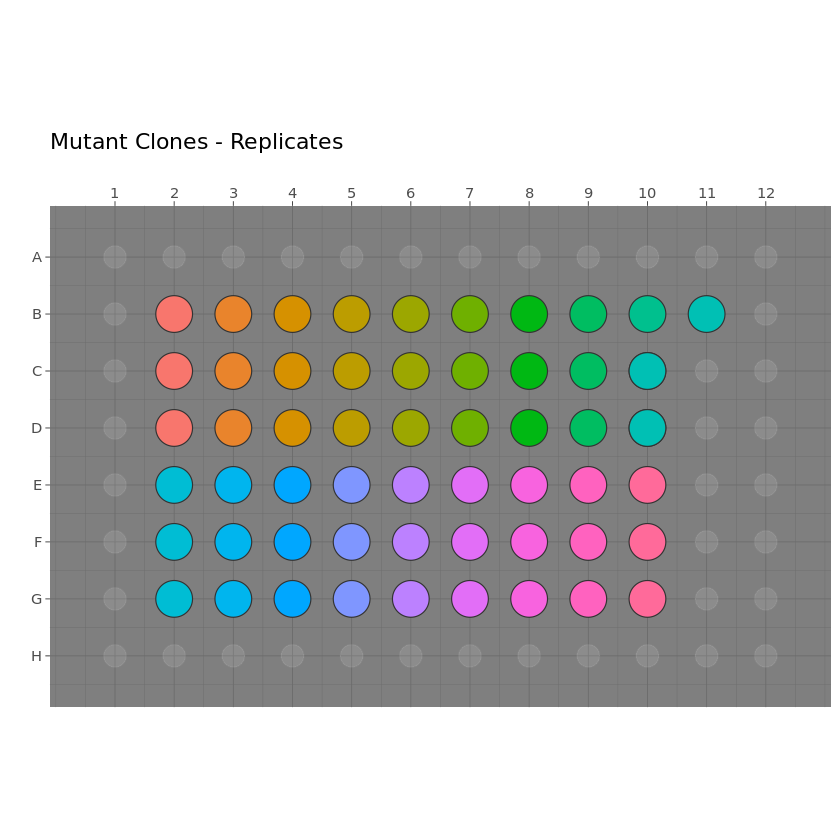

In [12]:
plate_mut_gg <- 
    platetools::raw_map(data = mut_df$Metadata_clone_number,
                        well = mut_df$Metadata_Well,
                        plate = 96) +
    ggtitle("Mutant Clones - Replicates") +
    theme_dark() +
    scale_fill_discrete() +
    theme(legend.position = "none")

fig_file <- file.path("figures", "plate_effects", paste0(batch, "_mut_replicates.png"))
ggsave(fig_file, height = 3, width = 5)

plate_mut_gg

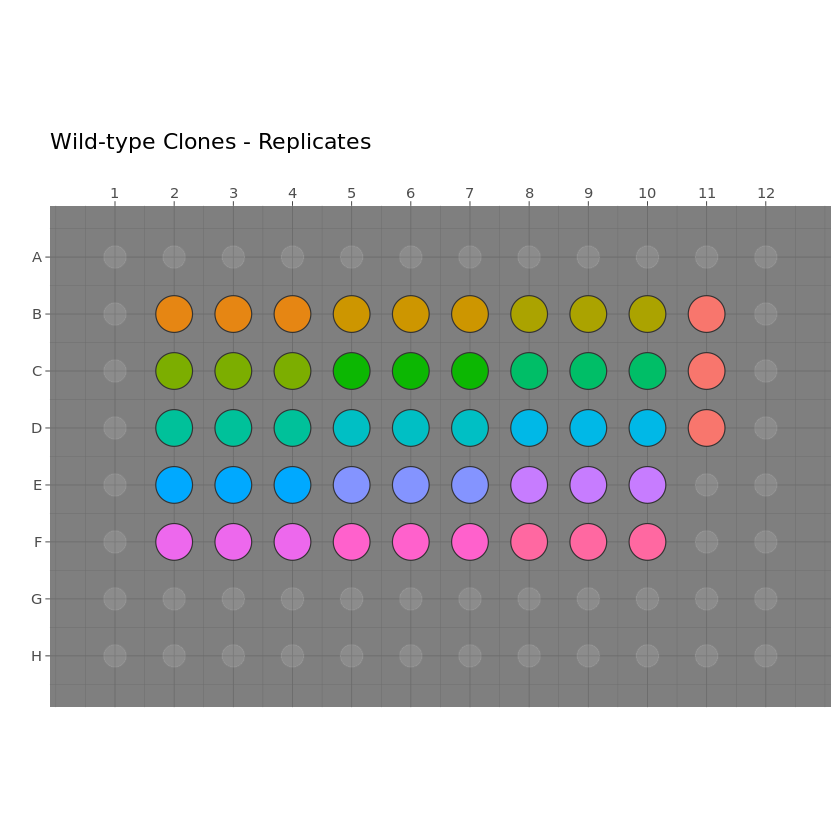

In [13]:
plate_wt_gg <- 
    platetools::raw_map(data = wt_df$Metadata_clone_number,
                        well = wt_df$Metadata_Well,
                        plate = 96) +
    ggtitle("Wild-type Clones - Replicates") +
    theme_dark() +
    scale_fill_discrete() +
    theme(legend.position = "none")

fig_file <- file.path("figures", "plate_effects", paste0(batch, "_wt_replicates.png"))
ggsave(fig_file, height = 3, width = 5)

plate_wt_gg

## Platemap for Cell Counts

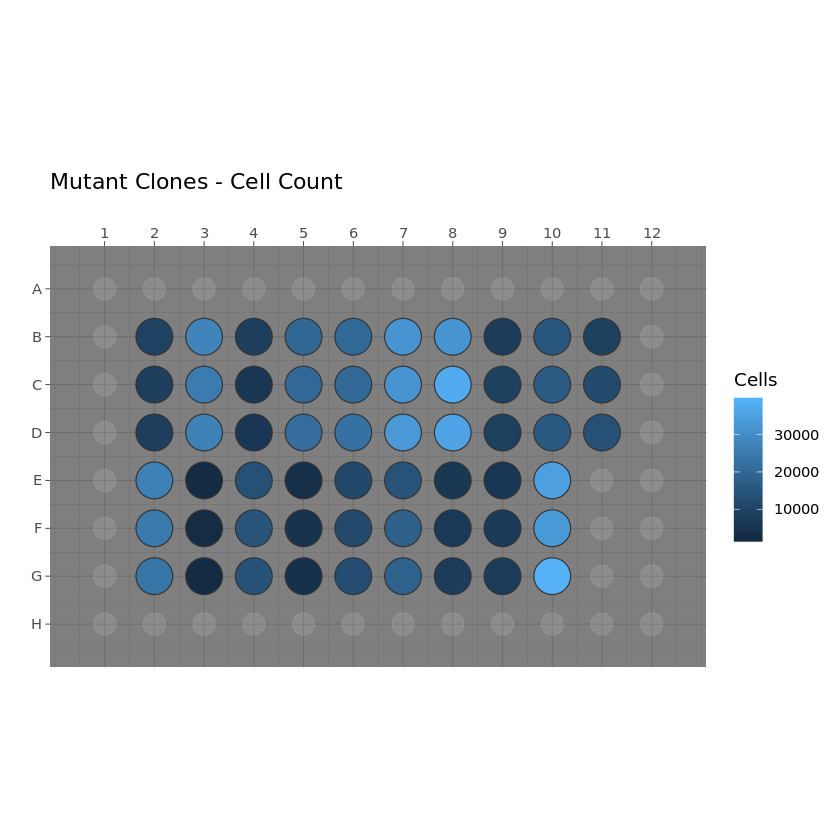

In [14]:
cell_count_mut_gg <- 
    platetools::raw_map(data = mut_count$n,
                        well = mut_count$Metadata_Well,
                        plate = 96) +
    ggtitle("Mutant Clones - Cell Count") +
    theme_dark() +
    scale_fill_continuous(name = "Cells")

fig_file <- file.path("figures", "plate_effects", paste0(batch, "_mut_cell_counts.png"))
ggsave(fig_file, height = 3, width = 5)

cell_count_mut_gg

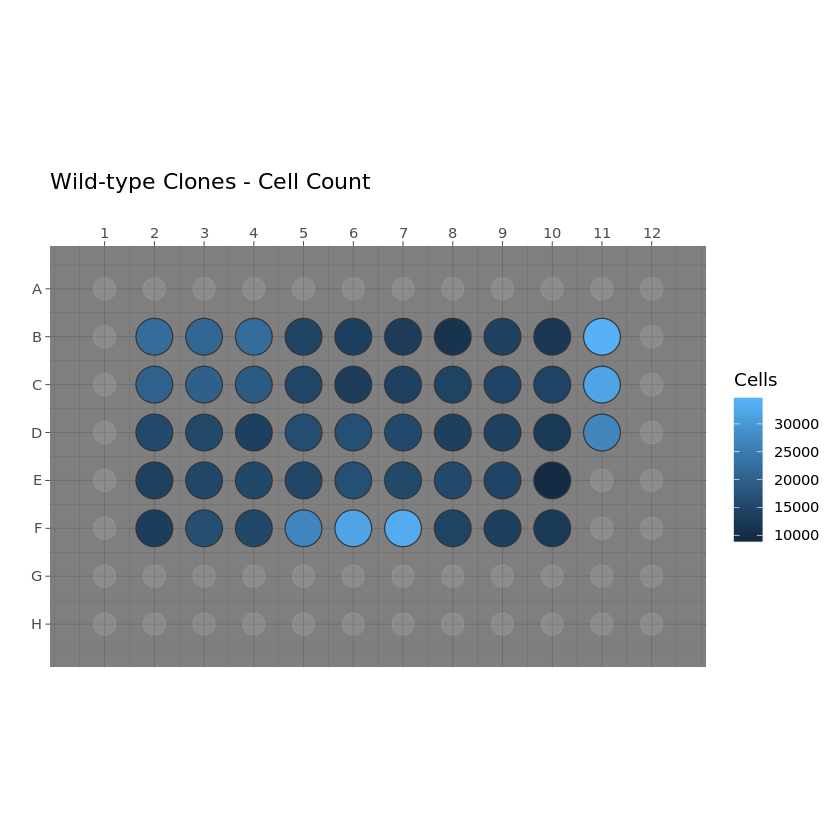

In [15]:
cell_count_wt_gg <- 
    platetools::raw_map(data = wt_count$n,
                        well = wt_count$Metadata_Well,
                        plate = 96) +
    ggtitle("Wild-type Clones - Cell Count") +
    theme_dark() +
    scale_fill_continuous(name = "Cells")

fig_file <- file.path("figures", "plate_effects", paste0(batch, "_wt_cell_counts.png"))
ggsave(fig_file, height = 3, width = 5)

cell_count_wt_gg

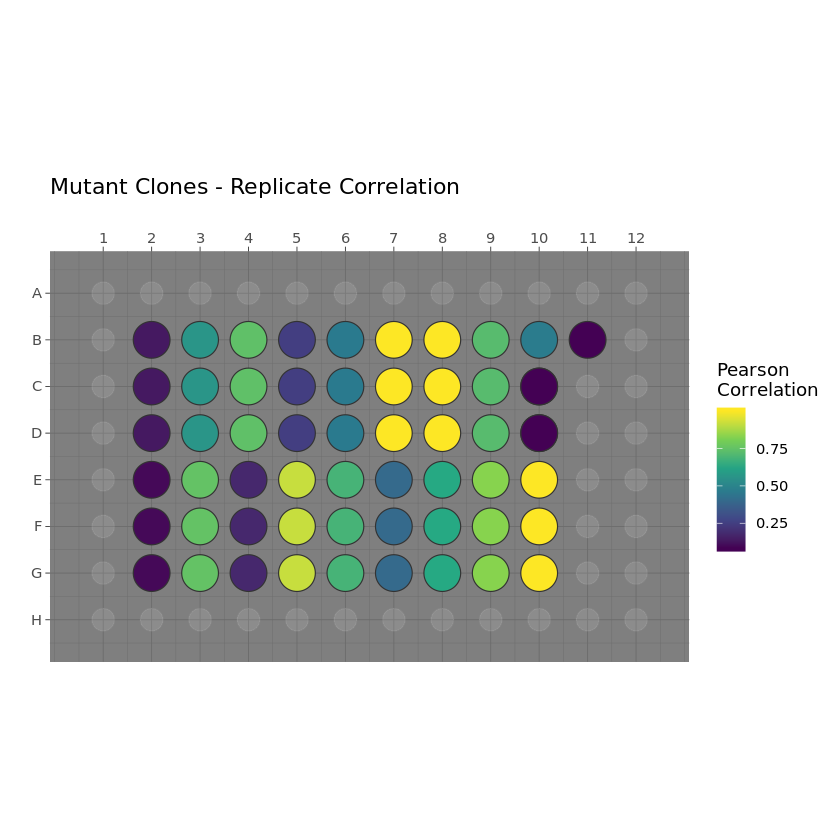

In [16]:
mut_replicate <- mut_median_cor_df %>% dplyr::filter(replicate)

cor_mut_gg <- 
    platetools::raw_map(data = mut_replicate$correlation,
                        well = mut_replicate$Metadata_Well,
                        plate = 96) +
    ggtitle("Mutant Clones - Replicate Correlation") +
    theme_dark() +
    scale_fill_continuous(type = "viridis", name = "Pearson\nCorrelation")

fig_file <- file.path("figures", "plate_effects", paste0(batch, "_mut_replicate_correlation.png"))
ggsave(fig_file, height = 3, width = 5)

cor_mut_gg

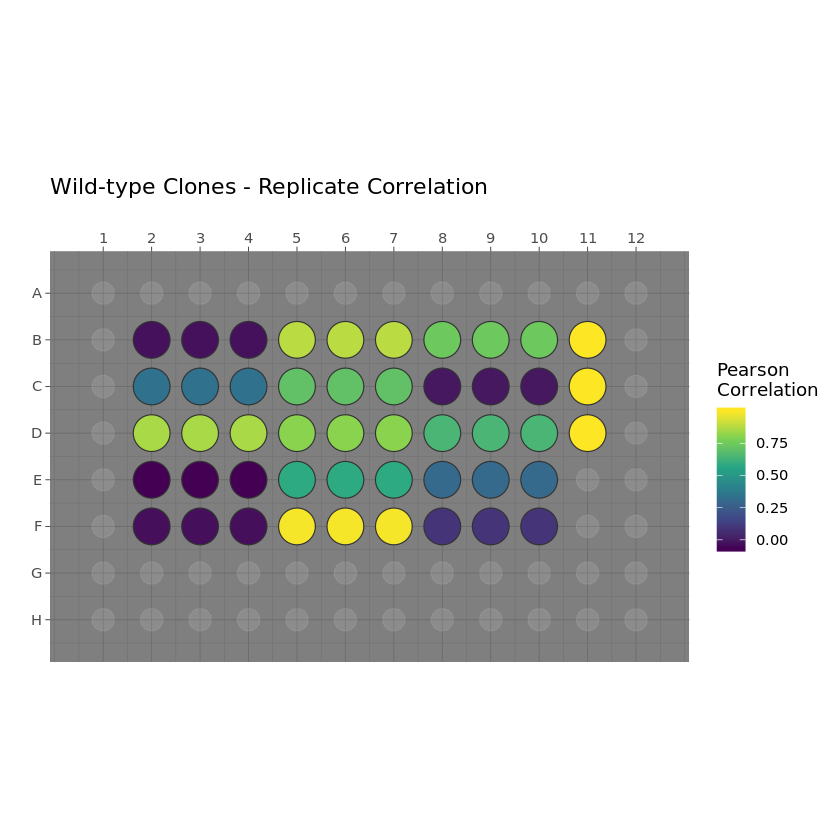

In [17]:
wt_replicate <- wt_median_cor_df %>% dplyr::filter(replicate)

cor_wt_gg <- 
    platetools::raw_map(data = wt_replicate$correlation,
                        well = wt_replicate$Metadata_Well,
                        plate = 96) +
    ggtitle("Wild-type Clones - Replicate Correlation") +
    theme_dark() +
    scale_fill_continuous(type = "viridis", name = "Pearson\nCorrelation")

fig_file <- file.path("figures", "plate_effects", paste0(batch, "_wt_replicate_correlation.png"))
ggsave(fig_file, height = 3, width = 5)

cor_wt_gg